In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
import pickle
import gzip

df = pd.read_csv('../Data/Border_Crossing_Entry_Data.csv')
df.head()





,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Roma,Texas,2310,US-Mexico Border,Dec 2023,Buses,46,26.404,-99.019,POINT (-99.018981 26.403928)
1,Del Rio,Texas,2302,US-Mexico Border,Dec 2023,Trucks,6552,29.327,-100.928,POINT (-100.927612 29.326784)
2,Roma,Texas,2310,US-Mexico Border,Nov 2023,Trucks,3753,26.404,-99.019,POINT (-99.018981 26.403928)
3,Douglas,Arizona,2601,US-Mexico Border,Oct 2023,Buses,13,31.334,-109.560,POINT (-109.560344 31.334043)
4,Beecher Falls,Vermont,206,US-Canada Border,Aug 2023,Trucks,422,45.013,-71.505,POINT (-71.505309 45.013411)


In [29]:
# convert String date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Port Name'].nunique()
df = df[(df['Border'] == 'US-Mexico Border')]

/var/folders/53/k6mgsl1x4071mwyh0yj504r00000gn/T/ipykernel_56899/1385852477.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


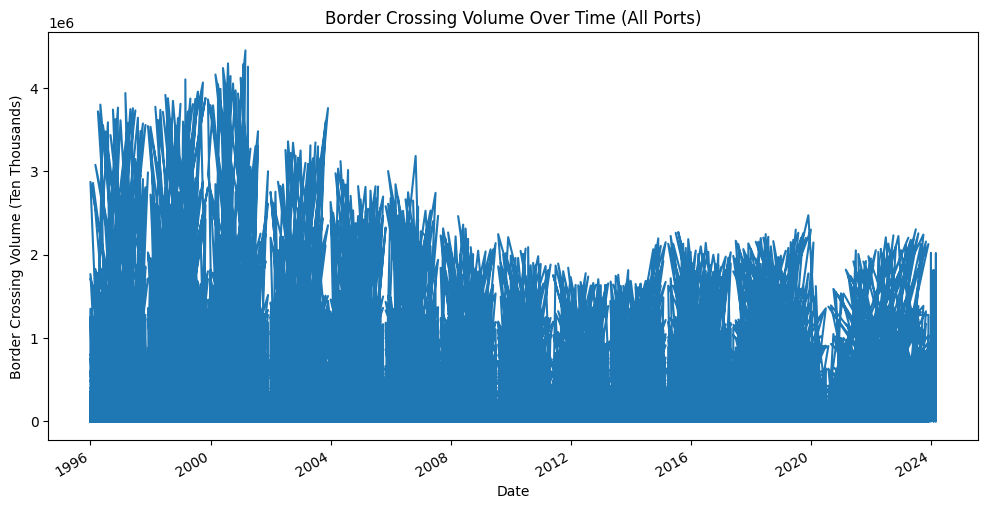

In [30]:
# plotting border crossing volume over time
plt.figure(figsize=(12, 6))
df.set_index('Date')['Value'].plot()
plt.title('Border Crossing Volume Over Time (All Ports)')
plt.xlabel('Date')
plt.ylabel('Border Crossing Volume (Ten Thousands)')
plt.show()

### Feature Engineering

In [31]:

lags = [1, 7, 30, 365]  # lag periods (in days)
for lag in lags:
    df[f'Latitude_Lag_{lag}'] = df['Latitude'].shift(lag)
    df[f'Longitude_Lag_{lag}'] = df['Longitude'].shift(lag)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92085 entries, 0 to 391042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Port Name          92085 non-null  object        
 1   State              92085 non-null  object        
 2   Port Code          92085 non-null  int64         
 3   Border             92085 non-null  object        
 4   Date               92085 non-null  datetime64[ns]
 5   Measure            92085 non-null  object        
 6   Value              92085 non-null  int64         
 7   Latitude           92085 non-null  float64       
 8   Longitude          92085 non-null  float64       
 9   Point              92085 non-null  object        
 10  Latitude_Lag_1     92084 non-null  float64       
 11  Longitude_Lag_1    92084 non-null  float64       
 12  Latitude_Lag_7     92078 non-null  float64       
 13  Longitude_Lag_7    92078 non-null  float64       
 14  Latitude_L

In [33]:
df.isnull().sum()
df.dropna(inplace=True)

### Model Training

In [34]:
features = ['Latitude', 'Longitude', 'Date', 'Latitude_Lag_1', 'Longitude_Lag_1']
target = 'Value'

train_data = df[df['Date'] < '2022-01-01']  
test_data = df[df['Date'] >= '2022-01-01']  

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (86623, 5) (86623,)
Testing set shape: (5097, 5) (5097,)


In [35]:
# Fit Arima Model for Sumas Port

# train_sumas_data = train_data[train_data['Port Name'] == 'Sumas']
# y_train_sumas = train_sumas_data[target]

# order = (1, 0, 0)  # (p, d, q)
# model = ARIMA(y_train_sumas, order=order)
# trained_model = model.fit()


# test_sumas_data = test_data[test_data['Port Name'] == 'Sumas']
# y_test_sumas = test_sumas_data[target]
# forecast = trained_model.forecast(steps=len(y_test_sumas))

# rmse = np.sqrt(mean_squared_error(y_test_sumas, forecast))
# mae = mean_absolute_error(y_test_sumas, forecast)


# print("Mean Absolute Error:", round(mae, 2))
# print("Root Mean Squared Error:", round(rmse, 2))





In [36]:
# Fit Arima Model for all Ports

trained_models = {}
evaluation_metrics = {}

for port_name in df['Port Name'].unique():
    train_port_data = train_data[train_data['Port Name'] == port_name]
    y_train_port = train_port_data[target]
    
    order = (1, 0, 0)  
    model = ARIMA(y_train_port, order=order)
    trained_model = model.fit()

    trained_models[port_name] = trained_model
    test_port_data = test_data[test_data['Port Name'] == port_name]
    y_test_port = test_port_data[target]
    
    if len(test_port_data) > 0:
        forecast = trained_model.forecast(steps=len(test_port_data))
        
        rmse = np.sqrt(mean_squared_error(y_test_port, forecast))
        mae = mean_absolute_error(y_test_port, forecast)
        
        evaluation_metrics[port_name] = {'RMSE': rmse, 'MAE': mae}
    else:
        print(f"Insufficient testing data available for port: {port_name}")
        # trained_models[port_name] = 'Insufficient data'
        

# Calculate average MAE and RMSE across all ports
mae_values = [metrics['MAE'] for metrics in evaluation_metrics.values()]
rmse_values = [metrics['RMSE'] for metrics in evaluation_metrics.values()]

average_mae = np.mean(mae_values)
average_rmse = np.mean(rmse_values)

print("Average Mean Absolute Error across all ports:", round(average_mae, 2))
print("Average Root Mean Squared Error across all ports:", round(average_rmse, 2))

/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

Average Mean Absolute Error across all ports: 115120.32
Average Root Mean Squared Error across all ports: 146297.4


/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24/datathon_env_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/collinshen/Documents/Collin/Collin_Projects/Dubstech-Datathon-24

In [37]:
# # Predicted Value for Port Sumas 2 year in the future
# prediction_date = '2026-01-01'
# prediction_2026_01_01 = trained_model.forecast(steps=1, index=pd.to_datetime([prediction_date]))

# print("Predicted value for January 1, 2026 for the 'Sumas' port:", round(prediction_2026_01_01[0], 2))


In [38]:

prediction_date = '2026-01-01'
predictions_2026_01_01 = {}

for port_name, trained_model in trained_models.items():

    prediction = trained_model.forecast(steps=1, index=pd.to_datetime([prediction_date]))
    predictions_2026_01_01[port_name] = round(prediction[0], 2)

print("Predictions for January 1, 2026:")
for port_name, prediction in predictions_2026_01_01.items():
    print(f"Port: {port_name}, Predicted Value: {prediction}")

Predictions for January 1, 2026:
Port: Lukeville, Predicted Value: 10874.03
Port: Otay Mesa, Predicted Value: 135109.64
Port: Progreso, Predicted Value: 35108.97
Port: Calexico, Predicted Value: 168985.74
Port: Calexico East, Predicted Value: 68098.23
Port: El Paso, Predicted Value: 328558.75
Port: Presidio, Predicted Value: 17494.69
Port: Santa Teresa, Predicted Value: 10032.19
Port: Andrade, Predicted Value: 24659.87
Port: Douglas, Predicted Value: 49266.16
Port: Hidalgo, Predicted Value: 175709.9
Port: Naco, Predicted Value: 8563.28
Port: Roma, Predicted Value: 27455.82
Port: Eagle Pass, Predicted Value: 75872.28
Port: San Ysidro, Predicted Value: 371879.38
Port: Tornillo, Predicted Value: 13755.46
Port: Tecate, Predicted Value: 29123.76
Port: Nogales, Predicted Value: 111489.27
Port: Columbus, Predicted Value: 10855.91
Port: Rio Grande City, Predicted Value: 17117.34
Port: Brownsville, Predicted Value: 153574.42
Port: Laredo, Predicted Value: 193771.75
Port: San Luis, Predicted Val

/var/folders/53/k6mgsl1x4071mwyh0yj504r00000gn/T/ipykernel_56899/1937668015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions_2026_01_01[port_name] = round(prediction[0], 2)
/var/folders/53/k6mgsl1x4071mwyh0yj504r00000gn/T/ipykernel_56899/1937668015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions_2026_01_01[port_name] = round(prediction[0], 2)
/var/folders/53/k6mgsl1x4071mwyh0yj504r00000gn/T/ipykernel_56899/1937668015.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

In [39]:
saved_data = {
    'trained_models': trained_models,
    'evaluation_metrics': evaluation_metrics,
    'average_mae': average_mae,
    'average_rmse': average_rmse,
    'predictions_2026_01_01': predictions_2026_01_01
}

pickle_file = 'trained_models.pkl'

with open(pickle_file, 'wb') as f:
    pickle.dump(saved_data, f)

print(f"Data saved to {pickle_file}")


Data saved to trained_models.pkl
